# Scan Maker

In this notebook we will show how to read an AOR and create scans starting from the information contained in the AOR.

The first case treated will be the AOR of an OTF observation.

We should be able to visualize the scans on a map to be sure that we are doing the right thing.

## How info is organized in the xml file of an AOR

It seems that:
1. the info is grouped into the tag: sspot.sofia.data.fifils.FIFI_LS_OTF
2. the <data> group contains all the data entered in uspot
3. <corners> contains the corners of the map
4. <mapPos> contains the beginning and end coordinates of each scan
5. <scanParams> contains the details of each scan (step, speed, direction)

# 1. Read the AOR

In [312]:
from xml.etree.ElementTree import ElementTree as ET

aorfile = '../test/AorSgrA.aor'
tree = ET(file=aorfile)


vector = tree.find('list/vector')
for child in vector:
    print(child.tag, child.attrib)
# Extract Target and Instrument from each AOR

targets = [item.text for item in vector.findall('Request/target/name')]
instruments = [item.text for item in vector.findall('Request/instrument/data/InstrumentName')]
print('instruments ',instruments)
print('targets ', targets)
print(vector[targets=='Sgr A'])

Request {}
Request {}
Request {}
Request {}
Request {}
Request {}
Request {}
Request {}
Request {}
Request {}
Request {}
Request {}
Request {}
Request {}
Request {}
Request {}
Request {}
Request {}
instruments  ['FIFI-LS', 'FIFI-LS', 'FIFI-LS', 'FIFI-LS', 'FIFI-LS', 'FIFI-LS', 'FIFI-LS', 'FIFI-LS', 'FIFI-LS', 'FIFI-LS', 'FIFI-LS', 'FIFI-LS', 'FIFI-LS', 'FIFI-LS', 'FIFI-LS', 'FIFI-LS', 'FIFI-LS', 'FIFI-LS']
targets  ['M82', 'M82', 'M82', 'M82', 'M82', 'M82', 'M82', 'M82', 'M82', 'M82', 'irc+10216', 'Sgr A', 'NGC40', 'NGC40', 'NGC40', 'NGC7027', 'NGC7027', 'NGC7027']
<Element 'Request' at 0x7fc73ba1d170>


In [313]:
abstract = tree.find('list/ProposalInfo/ProposalAbstract')
print('Abstract \n',abstract.text)
PropID = tree.find('list/ProposalInfo/ProposalID').text
print('prop ID: ', PropID)
PI = tree.find('list/ProposalInfo/Investigator')
PIname = PI.attrib['FirstName'] + ' ' + PI.attrib['LastName']
print('PI: ', PIname)

Abstract 
 We propose to test the possibility of implementing an OTF raster mapping mode for FIFI-LS. This mode will be almost identical to that used by the GREAT instrument and to take full 
advantage of the common KOSMA translator interface. We estimate this mode could increase the efficiency of large mapping done with FIFI-LS in total power mode by about 30%. In addition, it would result in much finer spatial sampling, which is clearly beneficial for FIFI-LS observations with its large (6” in the blue and 12” in the red) spaxels. In order to avoid undersampling the PSF with the large pixel scales, most FIFI-LS science observations are obtained in the chop-nod mode with multiple dither positions.  Such observations can be challenging for short 
integrations on large maps. In addition, OTF mapping will result in better self-flat-fielding of the data, since more FIFI-LS spaxels will integrate on the same positions on the sky. In 
summary, OTF mapping with FIFI-LS would greatly improve 

In [314]:
aorid = [item.text for item in vector.findall('Request/instrument/data/aorID')]
planmode = [item.text for item in vector.findall('Request/instrument/data/ObsPlanMode')]
primearray = [item.text for item in vector.findall('Request/instrument/data/PrimeArray')]
obslam = [item.text for item in vector.findall('Request/target/position/lon')]
obsbet= [item.text for item in vector.findall('Request/target/position/lat')]
maprotationangle = [item.text for item in vector.findall('Request/instrument/data/MapRotationAngle')]
print(maprotationangle)

['0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0']


[[11]]
<Element 'Request' at 0x7fc73bc3fad0>
plan mode OTF_MAP
['OTF_MAP']
det angle  11.299999999999955
RA, Dec  266.4168166666667 -29.007825


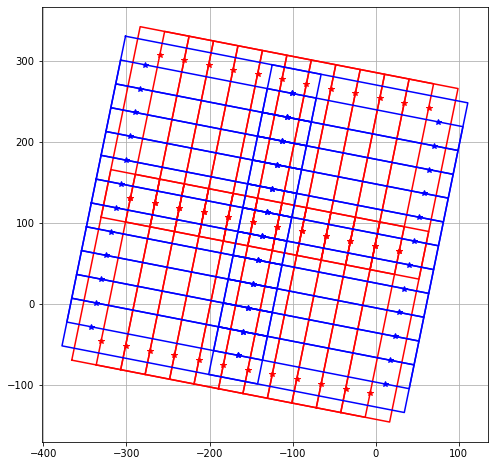

In [315]:
# Select one request based, e.g. on the target name (could be the aorid which is more unique)
# This is the case of map custom which is already a general case
# We should go back to the standard case of tiles
import numpy as np
requests = [item for item in vector.findall('Request')]
planmode = [item.text for item in vector.findall('Request/instrument/data/ObsPlanMode')]
targets = [item.text for item in vector.findall('Request/target/name')]
targets = np.array(targets)
requests = np.array(requests, dtype=object)
idx = np.argwhere(targets == 'Sgr A')
print(idx)
request = requests[targets=='Sgr A'][0]
print(request)
print('plan mode', request.findall('instrument/data/ObsPlanMode')[0].text)
planmode = np.array(planmode)
print(planmode[targets=='Sgr A'])

# How to compute the detector angle
detangle = float(request.findall('instrument/data/MapRotationAngle')[0].text)
#print('detangle ', detangle[0].text)
detangle = (((detangle + 11.3) + 180 + 360) % 360) - 180
print('det angle ', detangle)

scanpath = 'instrument/scanParams/sspot.sofia.data.fifils.ScanParameters/'
pos_lon = request.findall('target/position/lon')[0].text
pos_lat = request.findall('target/position/lat')[0].text
print('RA, Dec ', pos_lon, pos_lat)
dlam_map = [item.text for item in request.findall(scanpath+'deltaX')]
dbet_map = [item.text for item in request.findall(scanpath+'deltaY')]
skyspeed = [item.text for item in request.findall(scanpath+'scanSpeed')]
scandirection = [item.text for item in request.findall(scanpath+'scanDirection')]
velangle = []
for sc in scandirection:
    if sc == '+X': 
        va = 90
    elif sc == '-X':
        va = 270
    elif sc == '+Y':
        va = 0
    elif sc == '-Y':
        va = 180
    velangle.append(va)
velangle = np.array(velangle, dtype=float)
    
detang = detangle * np.pi / 180.0
cosa = np.cos(detang)
sina = np.sin(detang)
r = np.array([[cosa, -sina], [sina, cosa]])
dlam_map = np.array(dlam_map, dtype='float')
dbet_map = np.array(dbet_map, dtype='float')

# We should plot the first and last FOV
# The first is a square of 1'x1' (red) or "x30" (blue) centered on the starting point
# For the last, we have to compute the distance v * t (6 arcsec/sec * 60s = 360 arcsec) and
# add it to the initial position
# Compute final positions

# Scan length (sec) is contained in TimePerPoint ?
scantime = float(request.findall('instrument/data/TimePerPoint')[0].text)
#scantime = 30
# To be read from scanParams/scanSpeed
velocity = 6 # arcsec/sec
distance = velocity * scantime
dlam_end = dlam_map.copy()
dbet_end = dbet_map.copy()


idx = velangle == 90
if np.sum(idx) > 0:
    dlam_end[idx] += distance
idx = velangle == 270
if np.sum(idx) > 0:
    dlam_end[idx] -= distance
idx = velangle == 0
if np.sum(idx) > 0:
    dbet_end[idx] += distance
idx = velangle == 180
if np.sum(idx) > 0:
    dbet_end[idx] -= distance

x1, y1 = dlam_map.copy(), dbet_map.copy()
x2, y2 = dlam_map.copy(), dbet_map.copy()
x3, y3 = dlam_end.copy(), dbet_end.copy()
x4, y4 = dlam_end.copy(), dbet_end.copy()
   
    
    
mapoffsets = np.array([dlam_map, dbet_map])
rot_mapoffsets = np.dot(np.transpose(r), mapoffsets)
mapends = np.array([dlam_end, dbet_end])
rot_mapends = np.dot(np.transpose(r), mapends)

# Find the corners
dr = 30 # case of red array, half side is 30 arcsec
idx = velangle == 90
if np.sum(idx) > 0:
    x1[idx] -= dr
    x2[idx] -= dr
    x3[idx] += dr
    x4[idx] += dr
    y1[idx] += dr
    y2[idx] -= dr
    y3[idx] -= dr
    y4[idx] += dr
idx = velangle == 270
if np.sum(idx) > 0:
    x1[idx] += dr
    x2[idx] += dr
    x3[idx] -= dr
    x4[idx] -= dr
    y1[idx] += dr
    y2[idx] -= dr
    y3[idx] -= dr
    y4[idx] += dr
idx = velangle == 0
if np.sum(idx) > 0:
    x1[idx] -= dr
    x2[idx] += dr
    x3[idx] += dr
    x4[idx] -= dr
    y1[idx] -= dr
    y2[idx] -= dr
    y3[idx] += dr
    y4[idx] += dr
idx = velangle == 180
if np.sum(idx) > 0:
    x1[idx] -= dr
    x2[idx] += dr
    x3[idx] += dr
    x4[idx] -= dr
    y1[idx] += dr
    y2[idx] += dr
    y3[idx] -= dr
    y4[idx] -= dr


xy1 = np.array([x1, y1])
xy2 = np.array([x2, y2])
xy3 = np.array([x3, y3])
xy4 = np.array([x4, y4])
rxy1 = np.dot(np.transpose(r), xy1)
rxy2 = np.dot(np.transpose(r), xy2)
rxy3 = np.dot(np.transpose(r), xy3)
rxy4 = np.dot(np.transpose(r), xy4)


# matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
xoff = rot_mapoffsets[0]
yoff = rot_mapoffsets[1]
xend = rot_mapends[0]
yend = rot_mapends[1]
idx = (velangle == 0) | (velangle == 270)
fig,ax = plt.subplots(figsize=(8,8))
ax.plot([xoff[idx],xend[idx]], [yoff[idx],yend[idx]], '*r')
ax.plot([xoff[~idx],xend[~idx]], [yoff[~idx],yend[~idx]], '*b')
 
idx = (velangle == 0) | (velangle == 270)  
ax.plot([rxy1[0][idx],rxy2[0][idx],rxy3[0][idx],rxy4[0][idx],rxy1[0][idx]], 
        [rxy1[1][idx],rxy2[1][idx],rxy3[1][idx],rxy4[1][idx],rxy1[1][idx]], color='red')
ax.plot([rxy1[0][~idx],rxy2[0][~idx],rxy3[0][~idx],rxy4[0][~idx],rxy1[0][~idx]], 
        [rxy1[1][~idx],rxy2[1][~idx],rxy3[1][~idx],rxy4[1][~idx],rxy1[1][~idx]], color='blue')
    

ax.grid()
plt.show()

In [316]:
import urllib, urllib.request
def downloadWise(band, lon, lat, xsize, ysize):
        """ Download a Wise image """

        url = 'http://irsa.ipac.caltech.edu/ibe/search/wise/allsky/4band_p3am_cdd?POS='+\
                            "{0:.3f}".format(float(self.lon))+",{0:.3f}".format(float(self.lat))
        print(url)
        request = urllib.request.Request(url)
        response = urllib.request.urlopen(request)
        table = response.read()
        t = BytesIO(table)
        data = ascii.read(t,format='ipac')
        bands = data['band']
        coadds = data['coadd_id']
        bands = np.array(bands)
        coadds = np.array(coadds)
        coadd = coadds[bands == band]
        print(coadd)

        params = { 'coadd_id': coadd[0],'band': band,}
        params['coaddgrp'] = params['coadd_id'][:2]
        params['coadd_ra'] = params['coadd_id'][:4]
        path = str.format(
            '{coaddgrp:s}/{coadd_ra:s}/{coadd_id:s}/{coadd_id:s}-w{band:1d}-int-3.fits',
            **params)

        # We again specify center and size in WISE pixels (what is the pixel of WISE ? 1arcmin=45pix)
        #size=30,45arcsec
        #s1 = "{0:.0f}".format(pixscale[0]*60*ny*45)
        #s2 = "{0:.0f}".format(pixscale[1]*60*nx*45)
        s1 = "{0:.0f}".format(xsize*45)
        s2 = "{0:.0f}".format(ysize*45)

        url = 'http://irsa.ipac.caltech.edu/ibe/data/wise/allsky/4band_p3am_cdd/' + path+\
              "?center={0:.3f}".format(float(lon))+",{0:.3f}".format(float(lat))+"&size="+s1+','+s2+"pix&gzip=false"
        image_file = download_file(url,cache=True)

        with fits.open(image_file, memmap=False) as hdulist:
            header = hdulist['PRIMARY'].header
            data = hdulist['PRIMARY'].data
        return data, header


In [306]:
# Next: visualize on map
# 1. Transform center in (xc, yc)
# 2. Scale offsets to the size of image pixels
# 3. Add offsets to xc, yc and plot

from astroquery.skyview import SkyView
from astropy import units as u

# median position
lon = float(pos_lon)
lat = float(pos_lat)
mxoff = 0.5 * (np.nanmedian(xoff) + np.nanmedian(xend))
myoff = 0.5 * (np.nanmedian(yoff) + np.nanmedian(yend))
print(np.nanmedian(xoff), np.nanmedian(xend))
print('x,y off', mxoff, myoff)
myoff /= 3600.
mxoff /= 3600. / np.cos(lat * np.pi/180)

print('lon, lat' ,lon, lat)

lon += mxoff
lat += myoff

pos_lon = '{0:.5f}'.format(lon)
pos_lat = '{0:.5f}'.format(lat)


print('lon, lat' ,pos_lon, pos_lat)

paths = SkyView.get_images(position=pos_lon+','+pos_lat, survey='DSS2 Red',
                           pixels=1000) 
                           #width=0.05*u.deg, height=0.05*u.deg)
#paths = SkyView.get_images(position=pos_lon+','+pos_lat, survey='WISE 22', 
#                           pixels=1000, width=0.25*u.deg, height=0.25*u.deg)
#paths = SkyView.get_images(position=pos_lon+','+pos_lat, survey='2MASS-K', 
#                           pixels=1600, 
#                           width=0.25*u.deg, height=0.25*u.deg)

paths[0].writeto('../test/test.fits', overwrite=True)

-162.76789032139334 -103.98404704863827
x,y off -133.3759686850158 98.03494773464047
lon, lat 266.25472 -28.87167
lon, lat 266.22228 -28.84444


center at  498.61705953397865 499.3559989188749


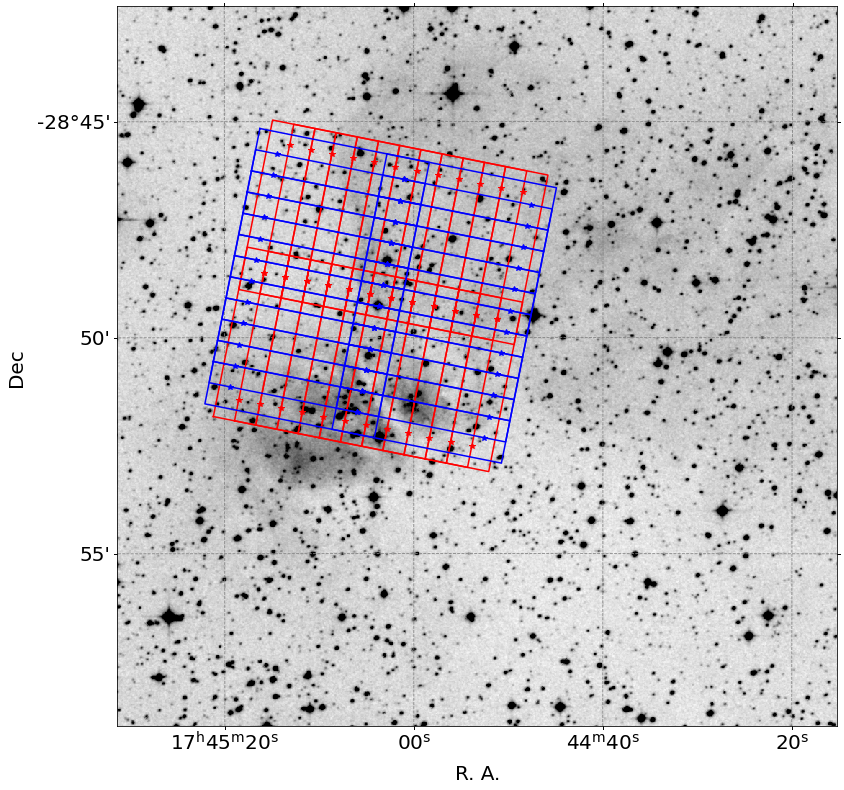

In [307]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.wcs.utils import proj_plane_pixel_scales as pixscales

#with fits.open('../test/test.fits') as hdul:
#    image = hdul[0].data
#    header = hdul[0].header
#wcs = WCS(header)
#pix = pixscales(wcs)[0]*3600. 
xsize=ysize=20 # minutes
image, header = downloadWise(band, pos_lon, pos_lat, xsize, ysize)
wcs = WCS(header)
pix = pixscales(wcs)[0]*3600. 



xc,yc = wcs.all_world2pix(float(pos_lon), float(pos_lat), 0)
print('center at ', xc, yc)

# Map
fig = plt.figure(figsize = (10,10))
ax = fig.add_axes([0.,0.,1.,1.], projection = wcs)
ax.coords[0].set_major_formatter('hh:mm:ss')
ax.set_xlabel('R. A.', fontsize=20)
ax.set_ylabel('Dec', fontsize=20)
ax.tick_params(axis='x', labelsize=20 )
ax.tick_params(axis='y', labelsize=20 )
image -= np.nanmedian(image)
ax.imshow(image, origin='lower',interpolation='nearest',cmap='gray_r', vmax=np.nanmax(image)*0.25)
ax.grid(color='gray', ls='dashed')

idx = (velangle == 0) | (velangle == 270)  
ax.plot([xoff[idx],xend[idx]]+xc, [yoff[idx],yend[idx]]+yc, '*r')
ax.plot([xoff[~idx],xend[~idx]]+xc, [yoff[~idx],yend[~idx]]+yc, '*b')
ax.plot([rxy1[0][idx],rxy2[0][idx],rxy3[0][idx],rxy4[0][idx],rxy1[0][idx]]+xc, 
        [rxy1[1][idx],rxy2[1][idx],rxy3[1][idx],rxy4[1][idx],rxy1[1][idx]]+yc, color='red')
ax.plot([rxy1[0][~idx],rxy2[0][~idx],rxy3[0][~idx],rxy4[0][~idx],rxy1[0][~idx]]+xc, 
        [rxy1[1][~idx],rxy2[1][~idx],rxy3[1][~idx],rxy4[1][~idx],rxy1[1][~idx]]+yc, color='blue')

plt.show()

255